# Dataset Exercise (March 2023)

## Problem Description
Consider a time series where data is generated from a function which randomly switches over 1 of N unknown distributions for a random period according to the program below. 
From the sample data file: <br>
(1) Estimate the number of distributions and characterize each <br>
(2) Create a general expression, algorithm (or code) which forecast the point at time t+1 given prior data for time <=t <br>
For this exercise, we are not looking for a unique solution, but the ability to estimate an approximate solution given a finite amount of effort.

## Solution

### <span style='color:blue'> Part I Estimate the number of distributions and characterize each </span>

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy import stats

# For plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from itertools import cycle

style.use('seaborn-poster')
sns.set_style('darkgrid')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Basic setup
# pd.set_option('display.max_columns', 50)
plt.style.use('bmh')
color_pal=plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle=cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [4]:
# Load the data
df = pd.read_csv('./exercise_data.csv')
df.shape

(10000, 2)

In [5]:
# View the data
df.head()

,time,value
0,1,100.000
1,2,100.880
2,3,101.252
3,4,100.699
4,5,100.728


In [6]:
# Check the summary statistics
df.describe()

,time,value
count,10000.00000,10000.000000
mean,5000.50000,98.194122
std,2886.89568,54.879001
min,1.00000,19.293200
25%,2500.75000,45.858275
50%,5000.50000,88.489700
75%,7500.25000,141.732000
max,10000.00000,250.851000


It shows that there is no `NaN` value in this dataset.

#### <span style='color:blue'>Visualization</span>
Let's plot these datapoints first so that we can have a general idea about its trend. 

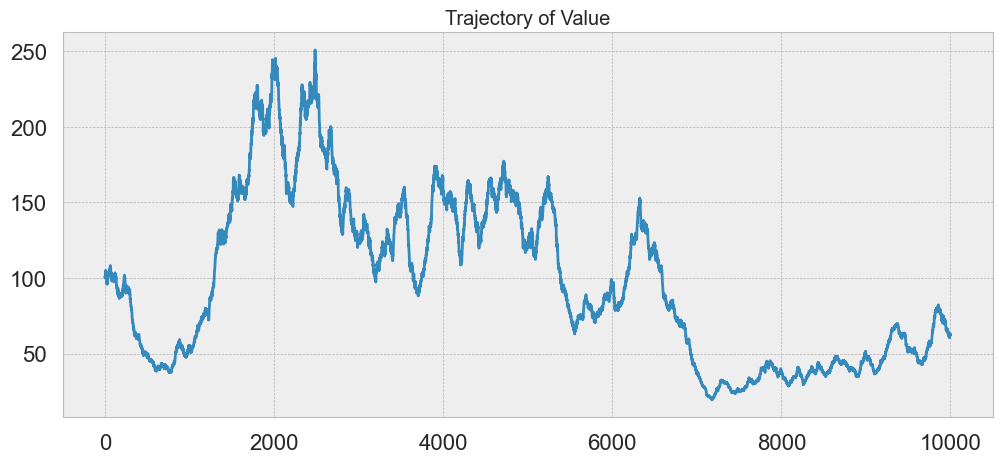

In [7]:
df['value'].plot(figsize=(12, 5), title='Trajectory of Value', color=next(color_cycle));

There are several methods for detecting the number of distributions in a dataset. Let's first try **histogram, boxplot and Quantile-Quantile plot**.

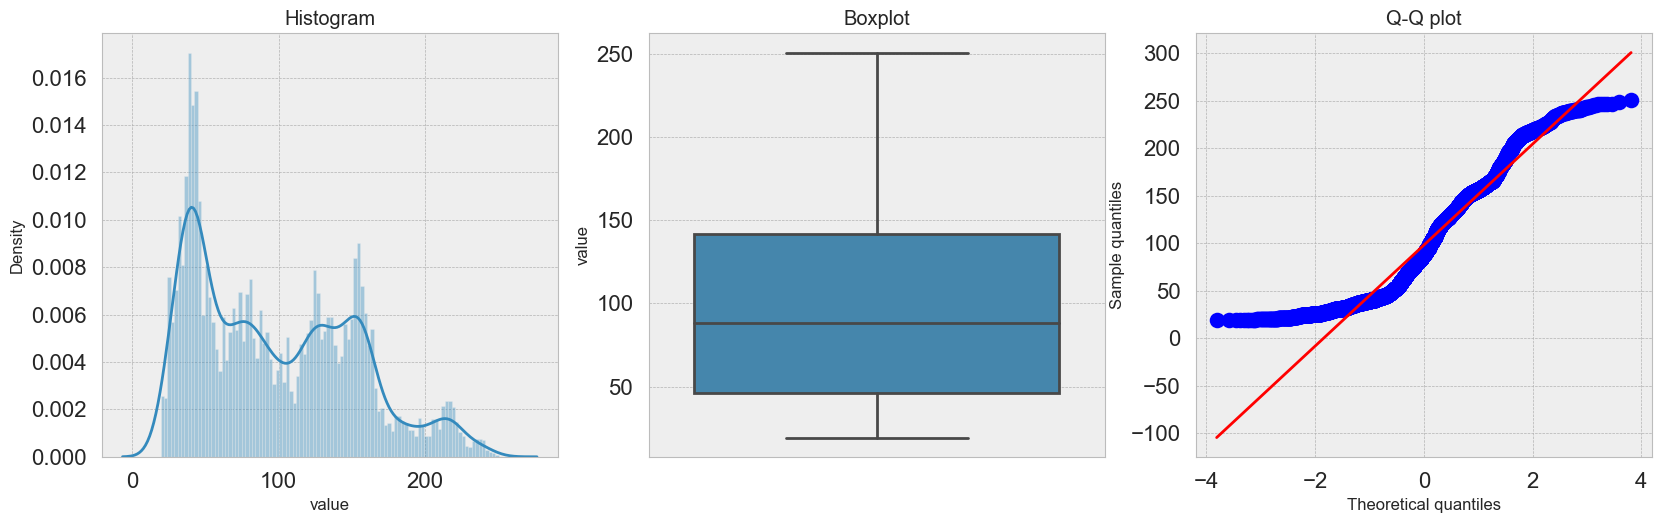

In [8]:
# Plotting and observing the distributions of data
plt.figure(figsize=(20, 5.5)) 
plt.subplot(1, 3, 1) # multiple plottig; 1st position of figure
sns.distplot(df['value'], bins=100) # plot a histrogram with a line on it
plt.title('Histogram') 
plt.subplot(1, 3, 2)  # 2nd position of figure
sns.boxplot(y=df['value']) # boxplot
plt.title('Boxplot')
plt.subplot(1, 3, 3) # 3rd position of figure
stats.probplot(df['value'], dist="norm", plot=plt) # Q-Q plot to check how our data is distributed in reference with a normal distribution
plt.ylabel('Sample quantiles')
plt.title('Q-Q plot');

<span style='color:green'>**Insights**</span>
1. From Q-Q plot, it shows that the data we have are far from a normal distribution since the data points at the left bottom and right upper of the plot deviate from the 45 degree straight line. 
2. We can visualy inspect the histogram for the number of peaks. Each peak may correspond to a separate distribution and thus the number of peaks can give us an estimate of the number of distributions in the data. That being said, it looks like that the data we have contain 5 distributions since there are 5 peaks. 

There are many techniques to estimate the number of distributions and their characteristics including statistical techniques such as clustering, hypothesis testing, and model selection. 
Here, **we will fit a mixture model to the data, which assumes that the data is generated from a combination of several underlying distributions. The number of distributions and their parameters can be estimated using maximum likelihood or Bayesian methods**. 

Next, let's use **Gaussian Mixture Model** to fit the data, which assumes that the data is generated from normal distributions. <br>

About Gaussian Mixture Model (GMM): <br>
* A Gaussian mixture model is a probabilistic model that assumes the data is generated by a mixture of Gaussian distributions, i.e., a weighted sum of Gaussian distributions. We can fit a Gaussian mixture model to the data using an algorithm such as the Expectation-Maximization algorithm, which estimates the parameters of each Gaussian distribution in the mixture. 
* In GMM, the number of Gaussian distributions (or components) in the mixture is a crucial parameter that needs to be determined to fit the data. The number of Gaussian distributions in the mixture can be selected based on the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC). The basic idea is to compute the BIC or AIC for different GMMs with different numbers of components and select the one with the lowest BIC or AIC value.
* The BIC is a measure of the goodness of fit of a statistical model, penalizing for the number of parameters in the model. **The BIC measures the trade-off between model fit and model complexity**. A lower BIC indicates a better fit with fewer parameters. Thus, it can be used for model selection, where the model with the lowest BIC is considered the best model. 
* The formula for BIC is given by: <br>
    BIC = -2 * log likelihood + k * log n, where k is the number of parameters in the model (i.e., the number of means, covariances, and mixture weights in GMM), and n is the sample size. **The BIC penalizes models with a large number of parameters more strongly than the AIC**.
* The formula for AIC is given by: <br>
    AIC = -2 * log likelihood + 2 * k, where k is the number of parameters in the model. The AIC penalizes models with a large number of parameters less strongly than the BIC.
* In general, both BIC and AIC tend to select the same number of components in GMM. However, **BIC tends to prefer simpler models with fewer components than AIC**. Therefore, if computational resources permit, it is recommended to compare the results of both criteria to determine the optimal number of components in GMM.

How to implement the BIC or AIC criterion to select the number of Gaussian distributions in a mixture model: <br>
1. Define the range of the number of Gaussian distributions to consider. This depends on the complexity of the data and prior knowledge of the number of clusters. 
2. Fit the mixture model for each number of Gaussian distributions in the range using an appropriate algorithm, such as expectation-maximization (EM) algorithm.
3. Calculate the likelihood of the data given the model for each number of Gaussian distributions using the log-likelihood function.
4. Calculate the BIC or AIC for each model using the formulas.
5. Choose the model with the lowest BIC or AIC as the best-fitting model.

First, let's fit GMM with 5 components based on our visually inspection of the histogram previously.

The means of GMM with 5 components are 
 [[ 40.09526343]
 [208.13018252]
 [123.27221675]
 [154.95982547]
 [ 79.21762617]] 

The covariances of GMM with 5 components are 
 [[[ 89.19527831]]

 [[321.65204727]]

 [[157.62072664]]

 [[120.3644557 ]]

 [[184.14768192]]] 

The weights of GMM with 5 components are 
 [0.33113714 0.08071649 0.18247268 0.17806765 0.22760604] 



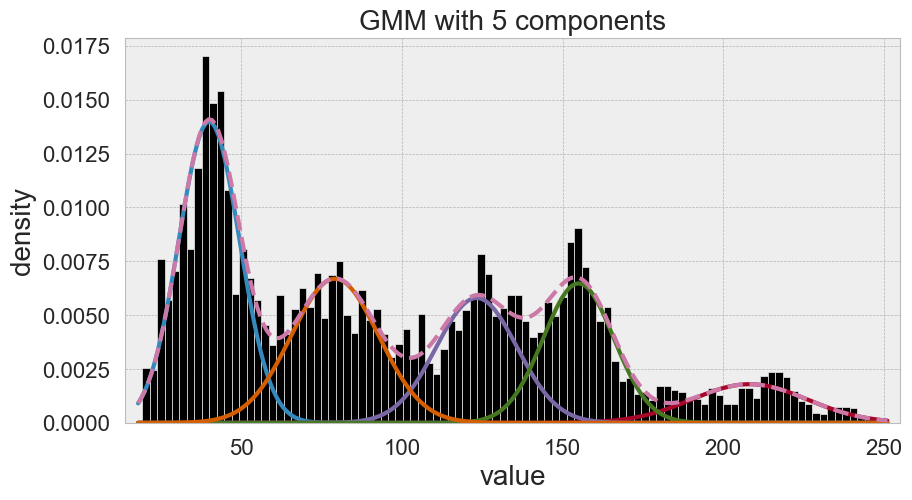

In [9]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

x = np.array(df['value']).reshape(-1, 1) # convert to a 2D array

num_cmp = 5; # consider 5 components now based on histogram

GMM = GaussianMixture(n_components=num_cmp, random_state=66).fit(x) # n_components is the number of underlying Gaussian distributions

# obtain the statistical parameters
mean = GMM.means_  
covs = GMM.covariances_
weights = GMM.weights_

print(f'The means of GMM with {num_cmp} components are \n {mean} \n')
print(f'The covariances of GMM with {num_cmp} components are \n {covs} \n')
print(f'The weights of GMM with {num_cmp} components are \n {weights} \n')

# create necessary variables for plotting
x_axis = np.arange(int(x.min())-1, int(x.max())+2, 1)
y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0]))) * weights[0] # 1st gaussian
y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0]))) * weights[1] # 2nd gaussian
y_axis2 = norm.pdf(x_axis, float(mean[2][0]), np.sqrt(float(covs[2][0][0]))) * weights[2] # 3rd gaussian
y_axis3 = norm.pdf(x_axis, float(mean[3][0]), np.sqrt(float(covs[3][0][0]))) * weights[3] # 4th gaussian
y_axis4 = norm.pdf(x_axis, float(mean[4][0]), np.sqrt(float(covs[4][0][0]))) * weights[4] # 5th gaussian

# plot
plt.figure(figsize=(10, 5))
plt.hist(x, density=True, color='black', bins=100)
plt.plot(x_axis, y_axis0, lw=3, c='C0')
plt.plot(x_axis, y_axis1, lw=3, c='C1')
plt.plot(x_axis, y_axis2, lw=3, c='C2')
plt.plot(x_axis, y_axis3, lw=3, c='C3')
plt.plot(x_axis, y_axis4, lw=3, c='C4')
plt.plot(x_axis, y_axis0+y_axis1+y_axis2+y_axis3+y_axis4, lw=3, c='C5', ls='dashed')
plt.xlim(int(x.min())-5, int(x.max())+5)
plt.xlabel('value', fontsize=20)
plt.ylabel('density', fontsize=20)
plt.title(f'GMM with {num_cmp} components', fontsize=20);

The GMM with 5 components looks good. Now let's utilize the BIC/AIC criterion to figure out the optimal number of components in a theoretical way. 

The means of GMM with 7 are 
 [[ 61.74494913]
 [217.00421606]
 [125.02756993]
 [183.2051354 ]
 [ 86.62695456]
 [154.25803492]
 [ 38.22834784]] 

The covariances of GMM with 7 are 
 [[[116.94276005]]

 [[163.38767794]]

 [[119.34539527]]

 [[125.64452192]]

 [[142.67117479]]

 [[ 74.56973749]]

 [[ 67.66064155]]] 

The weights of GMM with 7 are 
 [0.11730081 0.05598092 0.17386406 0.03837844 0.16706911 0.1590805
 0.28832616] 



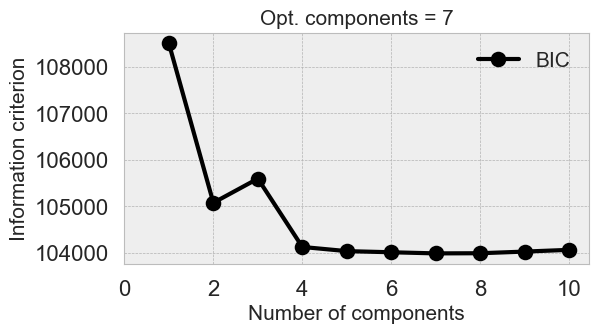

In [10]:
# let's figure out the optimal number of components
bics = []
min_bic = 0
counter = 1
for i in range(10): # test the AIC/BIC criterion between 1 and 10 components
    gmm = GaussianMixture(n_components=counter, max_iter=1000, random_state=66, covariance_type='full')
    labels = gmm.fit(x).predict(x) # predict the labels, i.e., the most likely Gaussian ddistribution of each data point in x
    bic = gmm.bic(x) # get the BIC criterion for the model
#     bic = gmm.aic(x) # get the AIC criterion for the model -> n_optimal=8
    bics.append(bic)
    if bic < min_bic or min_bic == 0:
        min_bic = bic
        opt_bic = counter
    counter = counter + 1

# plot the evolution of BIC/AIC with the number of components
fig = plt.figure(figsize=(6, 3))
plt.plot(np.arange(1,11), bics, 'o-', lw=3, c='black', label='BIC')
plt.legend(frameon=False, fontsize=15)
plt.xlabel('Number of components', fontsize=15)
plt.ylabel('Information criterion', fontsize=15)
plt.xticks(np.arange(0, 12, 2))
plt.title('Opt. components = ' + str(opt_bic), fontsize=15)

# Get the optimal value according to both BIC and AIC
n_optimal = opt_bic

GMM = GaussianMixture(n_components=n_optimal, random_state=66).fit(x) # n_components is the number of underlying Gaussian distributions

# obtain the statistical parameters
mean = GMM.means_  
covs = GMM.covariances_
weights = GMM.weights_

print(f'The means of GMM with {n_optimal} are \n {mean} \n')
print(f'The covariances of GMM with {n_optimal} are \n {covs} \n')
print(f'The weights of GMM with {n_optimal} are \n {weights} \n')

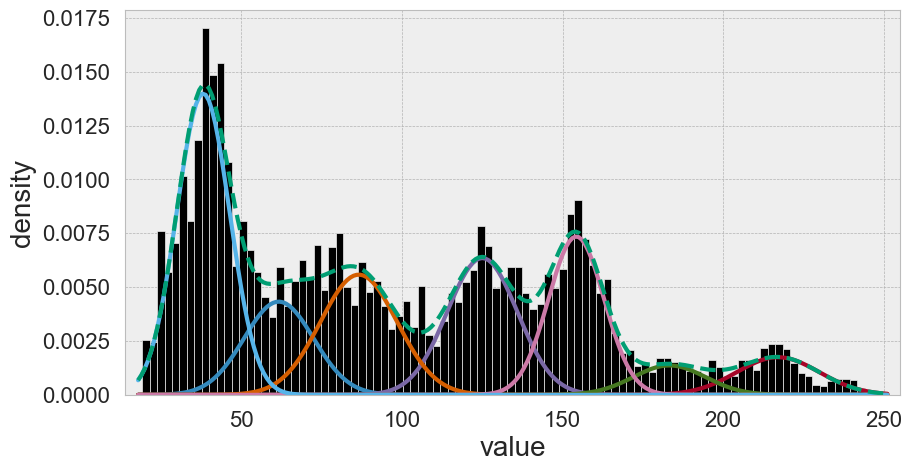

In [11]:
# create necessary variables for plotting
x_axis = np.arange(int(x.min())-1, int(x.max())+2, 1)
y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0]))) * weights[0] # 1st gaussian
y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0]))) * weights[1] # 2nd gaussian
y_axis2 = norm.pdf(x_axis, float(mean[2][0]), np.sqrt(float(covs[2][0][0]))) * weights[2] # 3rd gaussian
y_axis3 = norm.pdf(x_axis, float(mean[3][0]), np.sqrt(float(covs[3][0][0]))) * weights[3] # 4th gaussian
y_axis4 = norm.pdf(x_axis, float(mean[4][0]), np.sqrt(float(covs[4][0][0]))) * weights[4] # 5th gaussian
y_axis5 = norm.pdf(x_axis, float(mean[5][0]), np.sqrt(float(covs[5][0][0]))) * weights[5] # 6th gaussian
y_axis6 = norm.pdf(x_axis, float(mean[6][0]), np.sqrt(float(covs[6][0][0]))) * weights[6] # 7th gaussian

# plot
plt.figure(figsize=(10, 5))
plt.hist(x, density=True, color='black', bins=100)
plt.plot(x_axis, y_axis0, lw=3, c='C0')
plt.plot(x_axis, y_axis1, lw=3, c='C1')
plt.plot(x_axis, y_axis2, lw=3, c='C2')
plt.plot(x_axis, y_axis3, lw=3, c='C3')
plt.plot(x_axis, y_axis4, lw=3, c='C4')
plt.plot(x_axis, y_axis5, lw=3, c='C5')
plt.plot(x_axis, y_axis6, lw=3, c='C6')
plt.plot(x_axis, y_axis0+y_axis1+y_axis2+y_axis3+y_axis4+y_axis5+y_axis6, lw=3, c='C7', ls='dashed')
plt.xlim(int(x.min())-5, int(x.max())+5)
plt.xlabel('value', fontsize=20)
plt.ylabel('density', fontsize=20);

<span style='color:maroon'>**(1) Estimate the number of distributions and characterize each**</span> <br>
* According to the BIC criterion, the optimal number of components for GMM is 7, which is different from 5 that we figure out by visually inspecting the histogram. 
* The statistical characteristics of these 7 normal distributions are:

| Distributions | Mean | Covariance | Weights |
| --- | --- | --- | --- |
| 1 | 61.74494913 | 116.94276005 | 0.11730081 |
| 2 | 217.00421606 | 163.38767794 | 0.05598092 |
| 3 | 125.02756993 | 119.34539527 | 0.17386406 |
| 4 | 183.2051354 | 125.64452192 | 0.03837844 |
| 5 | 86.62695456 | 142.67117479 | 0.16706911 |
| 6 | 154.25803492 | 74.56973749 | 0.1590805 |
| 7 | 38.22834784 | 67.66064155 | 0.28832616 |

Based on the GMM results, we can predict the labels (i.e., the most likely Gaussian distribution) of each data point in the dataset.

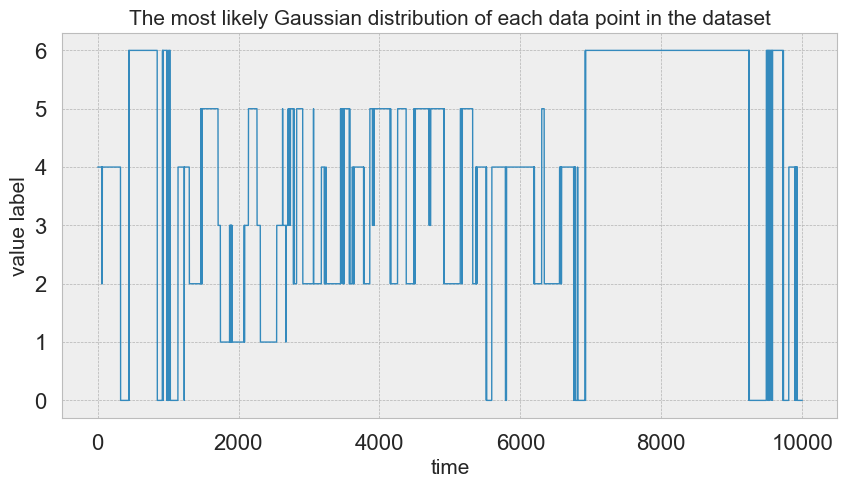

In [12]:
GMM = GaussianMixture(n_components=n_optimal, random_state=66).fit(x) # n_components is the number of underlying Gaussian distributions
labels = GMM.predict(x)

# plot the labels
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1,df.shape[0]+1,1), labels, lw=1, c='C0')
plt.xlabel('time', fontsize=15)
plt.ylabel('value label', fontsize=15)
plt.title('The most likely Gaussian distribution of each data point in the dataset', fontsize=15);

### <span style='color:blue'> Part II Create a general expression, algorithm (or code) which forecast the point at time t+1 given prior data for time <=t </span>

To forecast the point at time t+1 given prior data up until t, we can use time series forecasting methods such as ARIMA (Auto Regressive Integrated Moving Average), exponential smoothing, or neural networks. However, these methods assume that the data is generated from a stationary process (a stationary time series is one whose statistical properties such as mean, variance, and autocorrelation do not change over time.), which is not the case here since the data is generated from a function which randomly switches over 1 of N unknown distributions for a random period according to a specified program.

Therefore, we will solve this problem using **change point detection**. The idea of change point detection is to detect the points at which the distribution of the data changes. Once we have detected the change points, we can model each segment of the data using a separate distribution and use the models to forecast the next point.

The general steps of change point detection are:
1. Choose a change point detection algorithm: Apply a change point detection algorithm to the given data to detect the points at which the distribution changes.
2. Model each segment: Once the change points are detected, divide the data into segments and model each segment using a separate distribution such as Normal, Poisson, or Gamma.
3. Forecast: Use the models to forecast the next point.

As for the change point detection algorithm, here we choose **Pelt Algorithm**, which stands for **Pruned Exact Linear Time**. The Pelt algorithm is a popular method for detecting change points in time series data. The basic idea behind the Pelt algorithm is to divide the time series into segments that are homogeneous in terms of their statistical properties. A change point occurs when the statistical properties of the time series change abruptly.



Let's apply the Pelt Algorithm to the whole data to get a general idea of change points within the dataset.

The number of change points is 2846


<Figure size 1200x600 with 0 Axes>

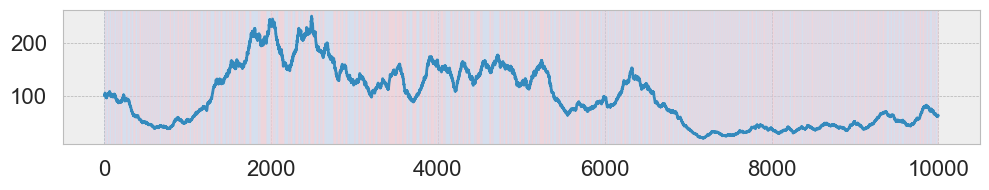

In [13]:
# ruptures is a Python library for off-line change point detection
# http://dev.ipol.im/~truong/ruptures-docs/build/html/general-info.html#user-guide
import ruptures as rpt # pip install ruptures
from scipy.stats import norm, poisson, gamma

# choose a change point detection algorithm
# algo = rpt.Pelt(model="l2", jump=1, min_size=1).fit(np.array(df['value']).reshape(-1,1))
algo = rpt.Pelt(model="l2", jump=1, min_size=1).fit(df) # Pruned Exact Linear Time (Pelt)
# https://centre-borelli.github.io/ruptures-docs/user-guide/detection/pelt/
# cost function: l2. predicted change points can only be a multiple of 'jump'.
# min_size: minimum number of samples between two change points.

# detect the change points
result = algo.predict(pen=10) # type of result is list; result[-1] = df.shape[0]-> the last change point is the end
print(f'The number of change points is {len(result)}')

# display
plt.figure(figsize=(12,6));
rpt.display(df['value'], result);

<span style='color:green'>**Insights**</span>
1. It can be seen from the above plot that the change points occur very frequently. This may add some difficulty for the forecasting later. 
2. For the `Pelt Algorithm`, there are some hypterparameters that we tune to influence the detection performance, which include `model`, `jump`, `min_size` and `pen`. Here,
    * `model` refers to the loss function;
    * `jump` refers to that the predicted change points can only be a multiple of `jump`;
    * `min_size` refers to the minimum number of samples between two change points;
    * `pen` refers to a penalty value. The smaller `pen` is, the more number of change points is detected.

**<span style='color:maroon'>(2) Algorithm to forecast the point at time t+1 given prior data for time <=t </span>** <br>
Based on the results of change point detection algorithm (i.e., `result`), next we will divide the data into segments and fit each segment using a separate normal distribution. As for forecasting the value at time instant `t+1`, we will use the model where the data point at time instant `t` belongs to to forecast its value. The specified algorithm to make predictions are summarized as follows:
1. Apply Pelt Algorithm to the data to obtain change point locations.
2. For $t=[2,..., n]$, where $n$ is the number of datapoints, find which segment the data point at $t-1$ belongs to based on the change point detection results. Here we will predict the point value at $t$ based on the past data up until $t-1$.
3. Fit a normal distribution based on this last segment. 
4. Predict the mean of the model for the last segment as the next point value.
    
The following figure gives an explanation of the proposed algorithm. 
<img src='plot.jpg' alt='Time Series Forecasting Algorithm' width='700'/>
    
The following are the codes to implement the proposed algorithm.

Mean squared error of predictions is 2.1210243281470795
The predicted value at 10000 is 62.630100000000006


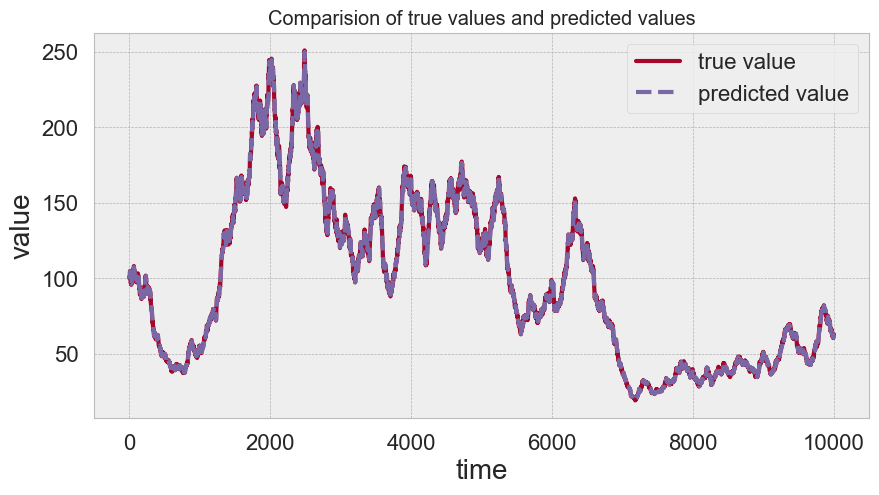

In [16]:
# make predictions 
pred = [df.at[0, 'value'], df.at[1, 'value']] # use the first two data points as the first two predictions

import bisect
span = df.shape[0]
for i in range(2, span+1): # predict value at i based on value up until i-1
    left_loc = bisect.bisect_left(result, i-1)
    if left_loc == 0: # edge case
        segment = np.array(df.loc[:i-1, 'value']).reshape(-1,1) # i-1 is inclusive
    else:
        segment = np.array(df.loc[result[left_loc-1]:i-1, 'value']).reshape(-1,1) # convert to 2D array
#     if len(segment) == 0: # for debugging
#         print(left_loc, i-1, segment)
    # fit a normal distribution to the data:
    last_model = norm.fit(segment) # return: (mu, std)
#     forecast = last_model[-2] + last_model[-1] # mean + std
    forecast = last_model[-2] # mean
    pred.append(forecast)
# Note here the code uses the model of the last segment to forecast the next point
    
# compute mean squared error
MSE = np.square(np.subtract(np.array(df['value'])[:span], np.array(pred)[:span])).mean()
print(f'Mean squared error of predictions is {MSE}')

print(f'The predicted value at {span} is {pred[-1]}')

# plot predictions
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1,span+1,1), df['value'][:span], lw=3, c='C1')
plt.plot(np.arange(1,span+2,1), pred, lw=3, c='C2', ls='dashed')
plt.xlabel('time', fontsize=20)
plt.ylabel('value', fontsize=20)
plt.legend(['true value', 'predicted value'])  
plt.title('Comparision of true values and predicted values');

Based on the simulation results, the MSE is about 2.12, which is pretty low. Also, the plot shows a good match between the true values and predicted values. 

<span style='color:green'>**Insights on the Proposed Model**</span>
* The implemented codes only consider the time span of the given dataset. Also, for fast implementation purpose, the codes compute all the change point locations all at once at first for the whole time span. But this could be further improved by computing the change point location for each new iteration. I tried to implement the codes in this way, but it turned out to be very slow even on Google Colab. 
* The proposed model can also be extended to predict values far into the future by adding the newly predicted values as the prior data points. In this way, we can utilize the predicted values to make predictions into the far future. 